In [1]:
# Change the path if necessary
datasets_path = 'datasets'

import sys
import os

# Deploy AML code in colab
if 'google.colab' in sys.modules:
    if not os.path.exists('/content/applied-ml/'):
        !wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
        import colab_github
        colab_github.github_auth(persistent_key=False)

        %cd /content/
        !git clone git@github.com:oz-e/applied-ml.git
        if not os.path.exists('/content/applied-ml/'):
            raise Exception('Please follow the instructions to add the SSH key to your account in order to clone private repo')

    %cd /content/applied-ml/

    # Install any other requirements (to be converted to requirements.txt)
    !pip install openai-clip

In [2]:
import os

if not os.path.exists('CuPL'):
    !git clone https://github.com/sarahpratt/CuPL.git

In [3]:
import numpy as np
import torch
import clip
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from CuPL.imagenet_prompts.standard_image_prompts import imagenet_templates

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
model, preprocess = clip.load('ViT-B/16', device=device, jit=False)

In [6]:
import aml.datasets

dataset_test = aml.datasets.Food101(datasets_path, split='test')

In [7]:
cls_names_sorted = [dataset_test.lab2cname[label_id] for label_id in sorted(dataset_test.lab2cname.keys())]

In [8]:
# Create class name features
with torch.no_grad():
    cls_name_label_ids = np.arange(len(cls_names_sorted))
    cls_name_features_cuda = model.encode_text(clip.tokenize(cls_names_sorted).to(device))
    cls_name_features_cuda /= cls_name_features_cuda.norm(dim=-1, keepdim=True)
    cls_name_features = cls_name_features_cuda.cpu().numpy()

    # Fill diagonal for better visibility
    cls_name_masked_similarity = (cls_name_features_cuda @ cls_name_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

In [9]:
def calc_features(encoder, items_dict):
    with torch.no_grad():
        label_ids = []
        features_cuda = []
        cls_features_cuda = []
        for label_id in tqdm(range(len(cls_names_sorted))):
            items = items_dict.pop(label_id)
            label_ids.append([label_id] * len(items))
            class_embeddings = encoder(items)
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            features_cuda.append(class_embeddings)
            cls_features_cuda.append(class_embedding)
        label_ids = np.hstack(label_ids)
        features = torch.vstack(features_cuda).cpu().numpy()
        cls_features_cuda = torch.vstack(cls_features_cuda)

        # Fill diagonal for better visibility
        masked_similarity = (cls_features_cuda @ cls_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

    return label_ids, features, features_cuda, cls_features_cuda, masked_similarity

In [10]:
def encode_text(texts):
    with torch.no_grad():
        return model.encode_text(clip.tokenize(texts).to(device))

In [11]:
# Create template text features
template_label_texts_list = {label_id: [template.format(cls_name) for template in imagenet_templates] for label_id, cls_name in enumerate(cls_names_sorted)}
template_label_ids, template_text_features, template_text_features_cuda, template_cls_features_cuda, template_masked_similarity = calc_features(encode_text, template_label_texts_list)

100%|██████████| 101/101 [00:02<00:00, 48.72it/s]


In [12]:
PATH_TO_PROMPTS = './CuPL/all_prompts/full_prompts/food_prompts_full.json'

with open(PATH_TO_PROMPTS) as f:
    gpt3_prompts_file = json.load(f)

In [13]:
# Mapping between CuPL and cls_name
special_class_mapping = {
}

In [14]:
# Lookup CuLP prompts from cls_name
original_gpt3_prompts = {}

for gpt3_cls_name, texts in gpt3_prompts_file.items():
    cls_name = special_class_mapping.get(gpt3_cls_name, gpt3_cls_name).replace(' ', '_')
    if cls_name not in dataset_test.classnames:
        continue
    original_gpt3_prompts[cls_name] = texts

In [15]:
# Create original gpt3 text features
original_gpt3_label_texts_list = {label_id: original_gpt3_prompts[cls_name] for label_id, cls_name in enumerate(cls_names_sorted)}
original_gpt3_label_ids, original_gpt3_text_features, original_gpt3_text_features_cuda, original_gpt3_cls_features_cuda, original_gpt3_masked_similarity = calc_features(encode_text, original_gpt3_label_texts_list)

100%|██████████| 101/101 [00:00<00:00, 120.17it/s]


In [16]:
# Filter out outliers in gpt3 text features
with torch.no_grad():
    original_gpt3_text_similarity = [(features_cuda @ features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy() for features_cuda in original_gpt3_text_features_cuda]
    original_gpt3_text_similarity_mean = [np.nanmean(similarity, axis=0) for similarity in original_gpt3_text_similarity]
    threshold = np.cos(np.deg2rad(45))
    filtered_gpt3_prompts = {label_id: [text for similarity, text in zip(original_gpt3_text_similarity_mean[label_id], original_gpt3_prompts[cls_name]) if similarity >= threshold] for label_id, cls_name in enumerate(cls_names_sorted)}
    filtered_gpt3_prompts = {label_id: list(dict.fromkeys(texts)) for label_id, texts in filtered_gpt3_prompts.items()}
    outliers = {label_id: [text for similarity, text in zip(original_gpt3_text_similarity_mean[label_id], original_gpt3_prompts[cls_name]) if similarity < threshold] for label_id, cls_name in enumerate(cls_names_sorted)}
    for label_id, texts in outliers.items():
        if len(texts) != 0:
            print(f'Filtered {len(texts)} outliers for ({label_id}){cls_names_sorted[label_id]}')
            print(texts)
            print()

Filtered 1 outliers for (2)baklava
['From the photo, it is difficult to say definitively what the food is.']

Filtered 1 outliers for (4)beef_tartare
['Ramen with a soft boiled eggRamen noodles in a broth with a soft boiled egg.']

Filtered 2 outliers for (5)beet_salad
['The salad contains red and golden beets, mixed greens, mandarin oranges, feta cheese, and a honey balsamic vinaigrette.', 'In the photo, there is a dish with various greens and red chunks.']

Filtered 1 outliers for (6)beignets
['.']

Filtered 2 outliers for (7)bibimbap
['.', '.']

Filtered 1 outliers for (8)bread_pudding
['The photo shows a dish with a brown crust and white interior.']

Filtered 1 outliers for (10)bruschetta
['The bread in this photo is toasted, and there is a red sauce on top.']

Filtered 1 outliers for (12)cannoli
['.']

Filtered 2 outliers for (14)carrot_cake
['.', 'The cake is shaped like a carrot, there are green leaves on top, and the name of the cake is written in icing on the plate.']

Filtere

In [17]:
# Create filtered gpt3 text features
filtered_gpt3_label_texts_list = {label_id: filtered_gpt3_prompts[label_id] for label_id in range(len(cls_names_sorted))}
filtered_gpt3_label_ids, filtered_gpt3_text_features, filtered_gpt3_text_features_cuda, filtered_gpt3_cls_features_cuda, filtered_gpt3_masked_similarity = calc_features(encode_text, filtered_gpt3_label_texts_list)

100%|██████████| 101/101 [00:00<00:00, 130.76it/s]


In [18]:
def encode_images(imgs):
    with torch.no_grad():
        return model.encode_image(torch.stack([preprocess(img) for img in imgs]).to(device))

In [19]:
# Create image features
imgs_grouped = defaultdict(list)
for img, label_id in dataset_test:
    imgs_grouped[label_id].append(img)
img_label_ids, _, img_features_cuda, _, img_masked_similarity = calc_features(encode_images, imgs_grouped)

100%|██████████| 101/101 [03:37<00:00,  2.15s/it]


In [20]:
import sklearn.metrics

def calc_clip_pred(label_ids, img_features_cuda, text_features_cuda):
    with torch.no_grad():
        if type(text_features_cuda) == list:  # list of tensors
            logits = torch.vstack([(img_features_cuda @ embeddings.T).mean(dim=-1) for embeddings in text_features_cuda]).T
        else:
            logits = img_features_cuda @ text_features_cuda.T
        pred = logits.argmax(dim=-1).cpu().numpy()

        return (pred == label_ids).mean(), sklearn.metrics.confusion_matrix(label_ids, pred, labels=np.arange(len(cls_names_sorted)), normalize='true')

In [21]:
# Combine template text with gpt3 text features
combined_original_gpt3_text_features_cuda = [torch.vstack((text_features1, text_features2)) for text_features1, text_features2 in zip(template_text_features_cuda, original_gpt3_text_features_cuda)]
combined_filtered_gpt3_text_features_cuda = [torch.vstack((text_features1, text_features2)) for text_features1, text_features2 in zip(template_text_features_cuda, filtered_gpt3_text_features_cuda)]
combined_original_gpt3_cls_features_cuda = []
combined_filtered_gpt3_cls_features_cuda = []
for class_embeddings in combined_original_gpt3_text_features_cuda:
    class_embedding = class_embeddings.mean(dim=0)
    class_embedding /= class_embedding.norm()
    combined_original_gpt3_cls_features_cuda.append(class_embedding)
for class_embeddings in combined_filtered_gpt3_text_features_cuda:
    class_embedding = class_embeddings.mean(dim=0)
    class_embedding /= class_embedding.norm()
    combined_filtered_gpt3_cls_features_cuda.append(class_embedding)
combined_original_gpt3_cls_features_cuda = torch.vstack(combined_original_gpt3_cls_features_cuda)
combined_filtered_gpt3_cls_features_cuda = torch.vstack(combined_filtered_gpt3_cls_features_cuda)

In [22]:
# Zero-shot classification of CLIP
img_features_stacked_cuda = torch.vstack(img_features_cuda)

cls_name_acc, cls_name_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, cls_name_features_cuda)
template_cls_acc, template_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, template_cls_features_cuda)
template_text_acc, template_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, template_text_features_cuda)
original_gpt3_cls_acc, original_gpt3_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, original_gpt3_cls_features_cuda)
original_gpt3_text_acc, original_gpt3_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, original_gpt3_text_features_cuda)
filtered_gpt3_cls_acc, filtered_gpt3_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, filtered_gpt3_cls_features_cuda)
filtered_gpt3_text_acc, filtered_gpt3_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, filtered_gpt3_text_features_cuda)
combined_original_gpt3_cls_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_original_gpt3_cls_features_cuda)
combined_original_gpt3_text_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_original_gpt3_text_features_cuda)
combined_filtered_gpt3_cls_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_filtered_gpt3_cls_features_cuda)
combined_filtered_gpt3_text_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_filtered_gpt3_text_features_cuda)

In [23]:
print(f'Accuracy of CLIP with class names: {cls_name_acc*100:.2f}%')
print(f'Accuracy of CLIP with text template (centroid): {template_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with text template (individual avg): {template_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with original GPT-3 text (centroid): {original_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with original GPT-3 text (individual avg): {original_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with filtered GPT-3 text (centroid): {filtered_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with filtered GPT-3 text (individual avg): {filtered_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined original GPT-3 text (centroid): {combined_original_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined original GPT-3 text (individual avg): {combined_original_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined filtered GPT-3 text (centroid): {combined_filtered_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined filtered GPT-3 text (individual avg): {combined_filtered_gpt3_text_acc*100:.2f}%')

Accuracy of CLIP with class names: 81.86%
Accuracy of CLIP with text template (centroid): 84.06%
Accuracy of CLIP with text template (individual avg): 83.89%
Accuracy of CLIP with original GPT-3 text (centroid): 86.10%
Accuracy of CLIP with original GPT-3 text (individual avg): 85.81%
Accuracy of CLIP with filtered GPT-3 text (centroid): 86.12%
Accuracy of CLIP with filtered GPT-3 text (individual avg): 85.76%
Accuracy of CLIP with combined original GPT-3 text (centroid): 85.24%
Accuracy of CLIP with combined original GPT-3 text (individual avg): 85.20%
Accuracy of CLIP with combined filtered GPT-3 text (centroid): 85.21%
Accuracy of CLIP with combined filtered GPT-3 text (individual avg): 85.16%


In [24]:
# Zero-shot classification of CLIP using one text on all images
template_text_individual_features_cuda = list(torch.stack(template_text_features_cuda).permute(1, 0, 2))
template_text_individual_acc = np.array([calc_clip_pred(img_label_ids, img_features_stacked_cuda, text_features_cuda)[0] for text_features_cuda in template_text_individual_features_cuda])
original_gpt3_text_individual_features_cuda = list(torch.stack(original_gpt3_text_features_cuda).permute(1, 0, 2))
original_gpt3_text_individual_acc = np.array([calc_clip_pred(img_label_ids, img_features_stacked_cuda, text_features_cuda)[0] for text_features_cuda in original_gpt3_text_individual_features_cuda])

In [25]:
print(f'Accuracy of CLIP with text template (one text on all images): mean={template_text_individual_acc.mean()*100:.2f}%, std={template_text_individual_acc.std()}')
print(f'Accuracy of CLIP with original GPT-3 text (one text on all images): mean={original_gpt3_text_individual_acc.mean()*100:.2f}%, std={original_gpt3_text_individual_acc.std()}')

Accuracy of CLIP with text template (one text on all images): mean=81.78%, std=0.028940349866202916
Accuracy of CLIP with original GPT-3 text (one text on all images): mean=78.62%, std=0.02670018905794761


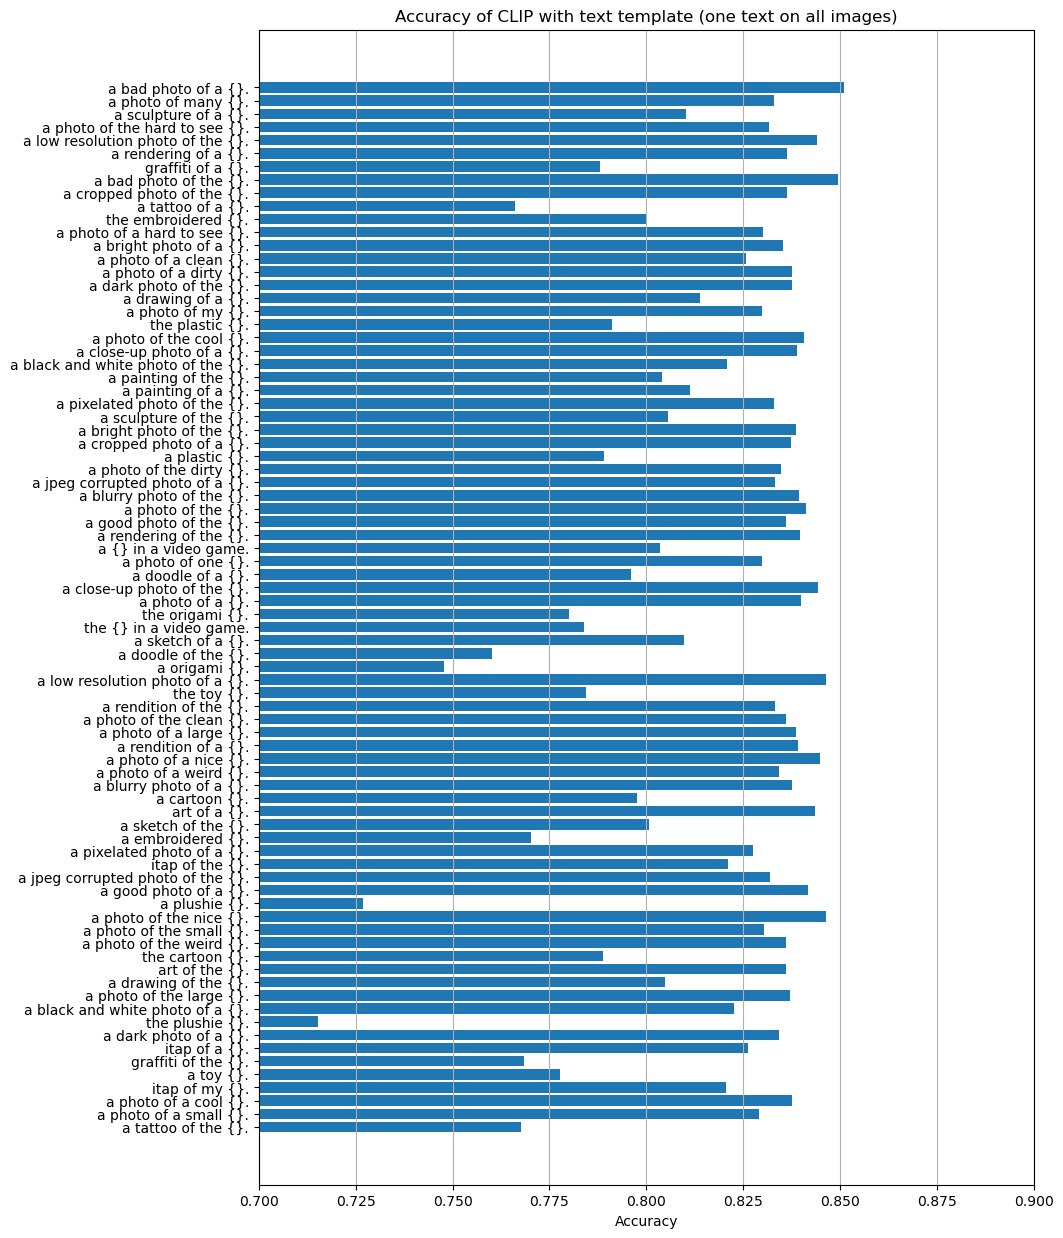

In [26]:
plt.figure(figsize=(10, 15))
plt.barh(np.arange(len(template_text_individual_acc)), template_text_individual_acc, align='center')
plt.yticks(np.arange(len(template_text_individual_acc)), imagenet_templates)
plt.xlabel('Accuracy')
plt.title('Accuracy of CLIP with text template (one text on all images)')
scale = 0.05
plt.xlim(int(template_text_individual_acc.min()/scale)*scale, (int(template_text_individual_acc.max()/scale)+1)*scale)
plt.grid(axis='x')
plt.gca().invert_yaxis()
plt.show()

In [27]:
def calc_features_similarity(features1_cuda, features2_cuda):
    with torch.no_grad():
        similarity_cuda = []
        for embeddings1 in features1_cuda:
            if type(features2_cuda) == list:  # list of tensors
                similarity_cuda.append(torch.Tensor([(embeddings1 @ embeddings2.T).mean() for embeddings2 in features2_cuda]))
            else:
                similarity_cuda.append((embeddings1 @ features2_cuda.T).mean(dim=0))

        return torch.vstack(similarity_cuda).cpu().numpy()

In [28]:
# Calculate similarity between image features and text features
img_cls_name_similarity = calc_features_similarity(img_features_cuda, cls_name_features_cuda)
img_template_cls_similarity = calc_features_similarity(img_features_cuda, template_cls_features_cuda)
img_template_text_similarity = calc_features_similarity(img_features_cuda, template_text_features_cuda)
img_original_gpt3_cls_similarity = calc_features_similarity(img_features_cuda, original_gpt3_cls_features_cuda)
img_original_gpt3_text_similarity = calc_features_similarity(img_features_cuda, original_gpt3_text_features_cuda)
img_filtered_gpt3_cls_similarity = calc_features_similarity(img_features_cuda, filtered_gpt3_cls_features_cuda)
img_filtered_gpt3_text_similarity = calc_features_similarity(img_features_cuda, filtered_gpt3_text_features_cuda)

In [29]:
def print_top_pairs(similarity, text, top=10):
    # Get the indices of top values
    top_indices = np.unravel_index(np.argsort(-similarity, axis=None)[:top], similarity.shape)

    # Extract the class names and labels for top values
    for idx, (label1, label2) in enumerate(zip(*top_indices)):
        print(f'Rank {idx+1}: ({label1}){cls_names_sorted[label1]} - ({label2}){cls_names_sorted[label2]}, {text}: {similarity[label1, label2]}')

In [30]:
def plot_similarity(similarity, title, xlabel=None, ylabel=None):
    plt.figure(figsize=(12, 10))
    plt.imshow(similarity)
    plt.xticks(np.arange(0, len(cls_names_sorted), 5))
    plt.yticks(np.arange(0, len(cls_names_sorted), 5))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    plt.title(title)
    plt.show()

In [31]:
def plot_cm(cm, title):
    plt.figure(figsize=(12, 10))
    plt.imshow(cm)
    plt.xticks(np.arange(0, len(cls_names_sorted), 5))
    plt.yticks(np.arange(0, len(cls_names_sorted), 5))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

In [32]:
def visualize_auto_similarity(masked_similarity, title):
    title_similarity = title + ' Similarity'
    print(f'{title_similarity.capitalize()} mean: {np.nanmean(masked_similarity)}')
    print(f'{title_similarity.capitalize()} std: {np.nanstd(masked_similarity)}')
    print_top_pairs(np.triu(masked_similarity, k=1), 'similarity')
    plot_similarity(masked_similarity, title_similarity)

In [33]:
def visualize_cross_similarity(similarity, cm, title, xlabel='Text', ylabel='Image'):
    title_similarity = title + ' Similarity'
    print(f'{title_similarity.capitalize()} mean: {np.mean(similarity)}')
    print(f'{title_similarity.capitalize()} std: {np.std(similarity)}')
    diagonal_similarity = similarity.diagonal()
    print(f'{title_similarity.capitalize()} diagonal mean: {np.mean(diagonal_similarity)}')
    print(f'{title_similarity.capitalize()} diagonal std: {np.std(diagonal_similarity)}')
    masked_similarity = similarity.copy()
    np.fill_diagonal(masked_similarity, np.nan)
    print(f'{title_similarity.capitalize()} non-diagonal mean: {np.nanmean(masked_similarity)}')
    print(f'{title_similarity.capitalize()} non-diagonal std: {np.nanstd(masked_similarity)}')
    print(f'{title_similarity.capitalize()} diagonal mean to non-diagonal mean ratio: {np.mean(diagonal_similarity)/np.nanmean(masked_similarity)}')
    print_top_pairs(masked_similarity, 'similarity', top=20)
    plot_similarity(similarity, title_similarity, xlabel=xlabel, ylabel=ylabel)
    masked_cm = cm.copy()
    np.fill_diagonal(masked_cm, np.nan)
    print_top_pairs(masked_cm, 'error rate', top=20)
    plot_cm(cm, title + ' Confusion Matrix')

Class name similarity mean: 0.7060546875
Class name similarity std: 0.055145263671875
Rank 1: (45)frozen_yogurt - (58)ice_cream, similarity: 0.9013671875
Rank 2: (72)pancakes - (100)waffles, similarity: 0.8916015625
Rank 3: (21)chocolate_cake - (22)chocolate_mousse, similarity: 0.890625
Rank 4: (37)filet_mignon - (93)steak, similarity: 0.87744140625
Rank 5: (38)fish_and_chips - (40)french_fries, similarity: 0.87646484375
Rank 6: (66)nachos - (96)tacos, similarity: 0.873046875
Rank 7: (86)sashimi - (95)sushi, similarity: 0.87158203125
Rank 8: (4)beef_tartare - (99)tuna_tartare, similarity: 0.86572265625
Rank 9: (76)pizza - (93)steak, similarity: 0.865234375
Rank 10: (21)chocolate_cake - (29)cup_cakes, similarity: 0.8642578125


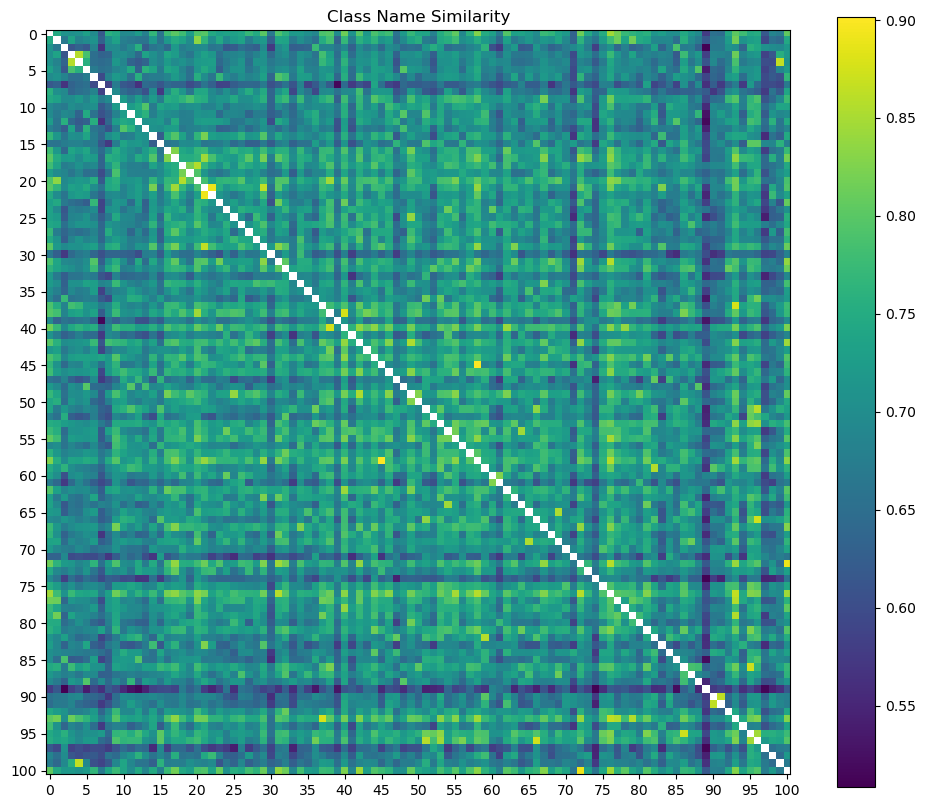

Text template similarity mean: 0.70361328125
Text template similarity std: 0.057373046875
Rank 1: (21)chocolate_cake - (22)chocolate_mousse, similarity: 0.90283203125
Rank 2: (45)frozen_yogurt - (58)ice_cream, similarity: 0.8994140625
Rank 3: (4)beef_tartare - (99)tuna_tartare, similarity: 0.8974609375
Rank 4: (86)sashimi - (95)sushi, similarity: 0.8896484375
Rank 5: (37)filet_mignon - (93)steak, similarity: 0.8876953125
Rank 6: (72)pancakes - (100)waffles, similarity: 0.88720703125
Rank 7: (53)hamburger - (93)steak, similarity: 0.88671875
Rank 8: (77)pork_chop - (93)steak, similarity: 0.88134765625
Rank 9: (53)hamburger - (55)hot_dog, similarity: 0.86474609375
Rank 10: (79)prime_rib - (93)steak, similarity: 0.86474609375


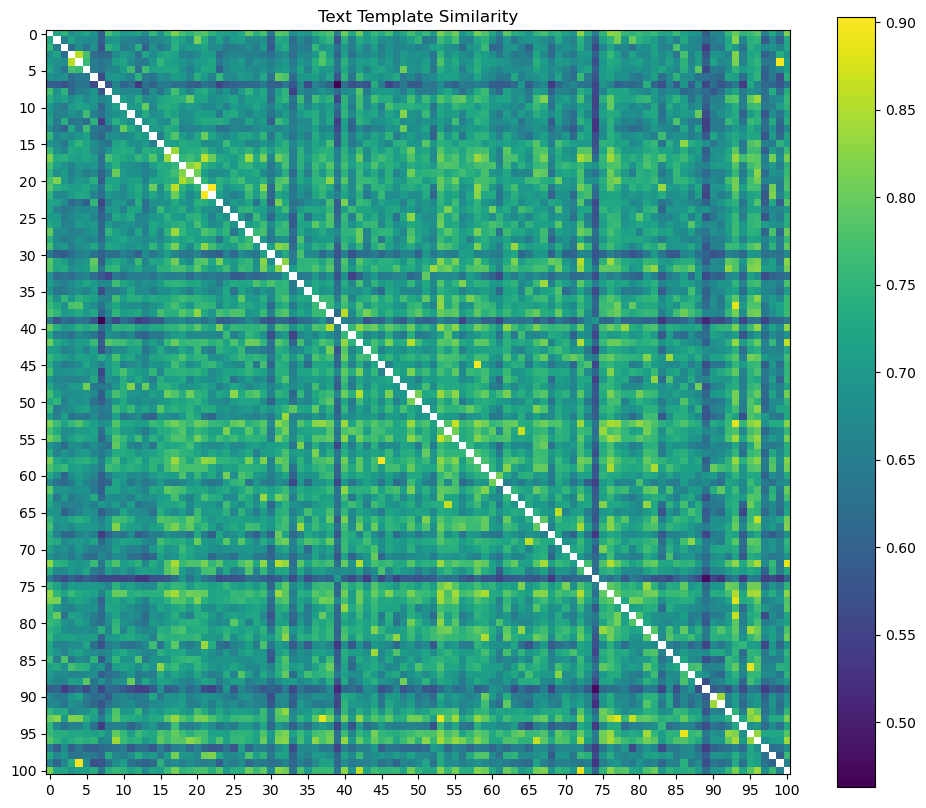

Original gpt-3 text similarity mean: 0.71533203125
Original gpt-3 text similarity std: 0.061492919921875
Rank 1: (37)filet_mignon - (93)steak, similarity: 0.93505859375
Rank 2: (45)frozen_yogurt - (58)ice_cream, similarity: 0.9306640625
Rank 3: (4)beef_tartare - (99)tuna_tartare, similarity: 0.91650390625
Rank 4: (86)sashimi - (95)sushi, similarity: 0.91552734375
Rank 5: (79)prime_rib - (93)steak, similarity: 0.9150390625
Rank 6: (77)pork_chop - (93)steak, similarity: 0.90576171875
Rank 7: (53)hamburger - (55)hot_dog, similarity: 0.90478515625
Rank 8: (21)chocolate_cake - (22)chocolate_mousse, similarity: 0.90185546875
Rank 9: (72)pancakes - (100)waffles, similarity: 0.90087890625
Rank 10: (54)hot_and_sour_soup - (64)miso_soup, similarity: 0.8984375


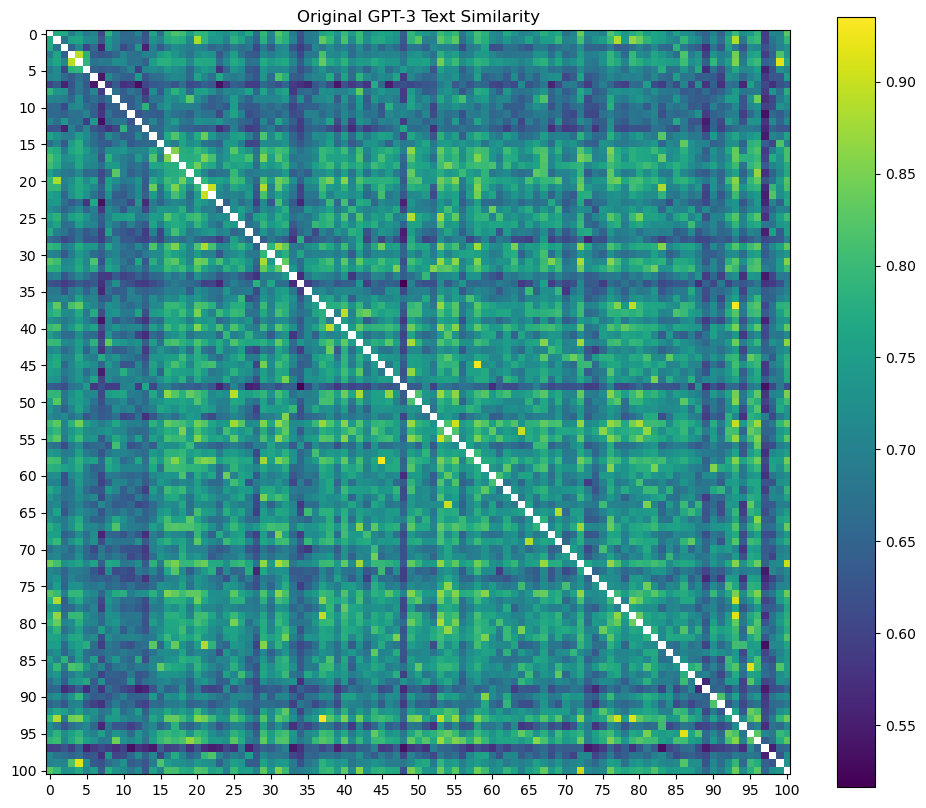

Filtered gpt-3 text similarity mean: 0.708984375
Filtered gpt-3 text similarity std: 0.06396484375
Rank 1: (37)filet_mignon - (93)steak, similarity: 0.9365234375
Rank 2: (45)frozen_yogurt - (58)ice_cream, similarity: 0.927734375
Rank 3: (86)sashimi - (95)sushi, similarity: 0.9140625
Rank 4: (79)prime_rib - (93)steak, similarity: 0.91162109375
Rank 5: (4)beef_tartare - (99)tuna_tartare, similarity: 0.91015625
Rank 6: (77)pork_chop - (93)steak, similarity: 0.90576171875
Rank 7: (53)hamburger - (55)hot_dog, similarity: 0.904296875
Rank 8: (72)pancakes - (100)waffles, similarity: 0.90087890625
Rank 9: (53)hamburger - (93)steak, similarity: 0.89697265625
Rank 10: (21)chocolate_cake - (22)chocolate_mousse, similarity: 0.89599609375


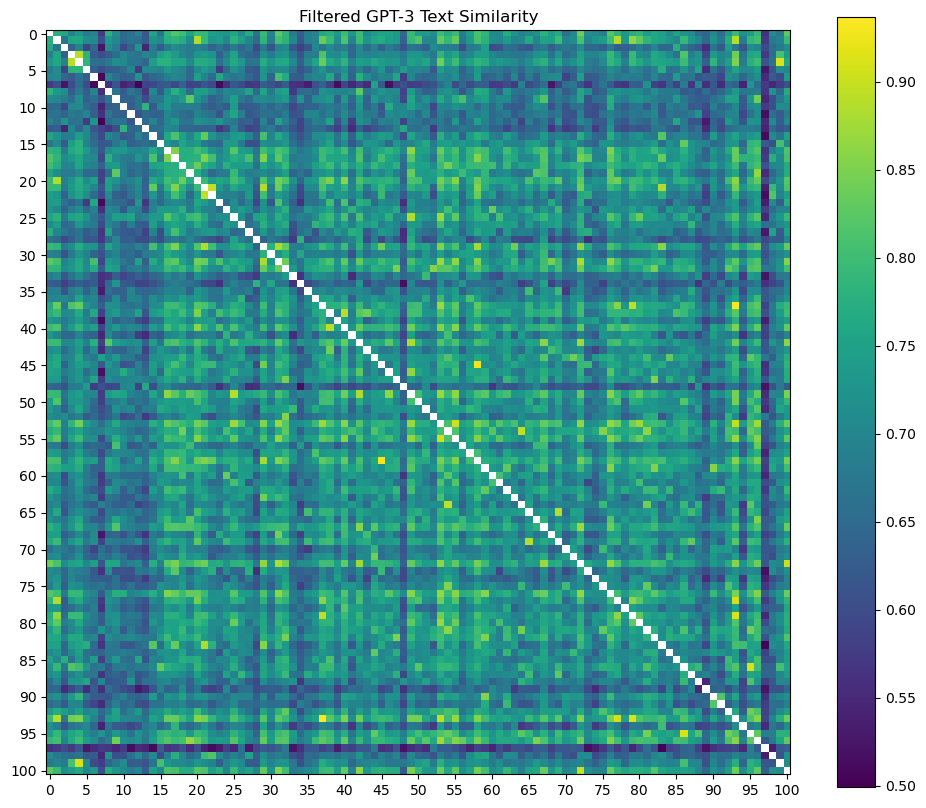

In [34]:
# Auto-similarity of text features
visualize_auto_similarity(cls_name_masked_similarity, 'Class Name')
visualize_auto_similarity(template_masked_similarity, 'Text Template')
visualize_auto_similarity(original_gpt3_masked_similarity, 'Original GPT-3 Text')
visualize_auto_similarity(filtered_gpt3_masked_similarity, 'Filtered GPT-3 Text')

Image similarity mean: 0.830078125
Image similarity std: 0.04644775390625
Rank 1: (37)filet_mignon - (93)steak, similarity: 0.9873046875
Rank 2: (47)gnocchi - (82)ravioli, similarity: 0.9736328125
Rank 3: (77)pork_chop - (93)steak, similarity: 0.970703125
Rank 4: (37)filet_mignon - (77)pork_chop, similarity: 0.97021484375
Rank 5: (4)beef_tartare - (99)tuna_tartare, similarity: 0.9697265625
Rank 6: (22)chocolate_mousse - (98)tiramisu, similarity: 0.96923828125
Rank 7: (79)prime_rib - (93)steak, similarity: 0.96875
Rank 8: (9)breakfast_burrito - (19)chicken_quesadilla, similarity: 0.96435546875
Rank 9: (0)apple_pie - (8)bread_pudding, similarity: 0.96337890625
Rank 10: (21)chocolate_cake - (22)chocolate_mousse, similarity: 0.962890625


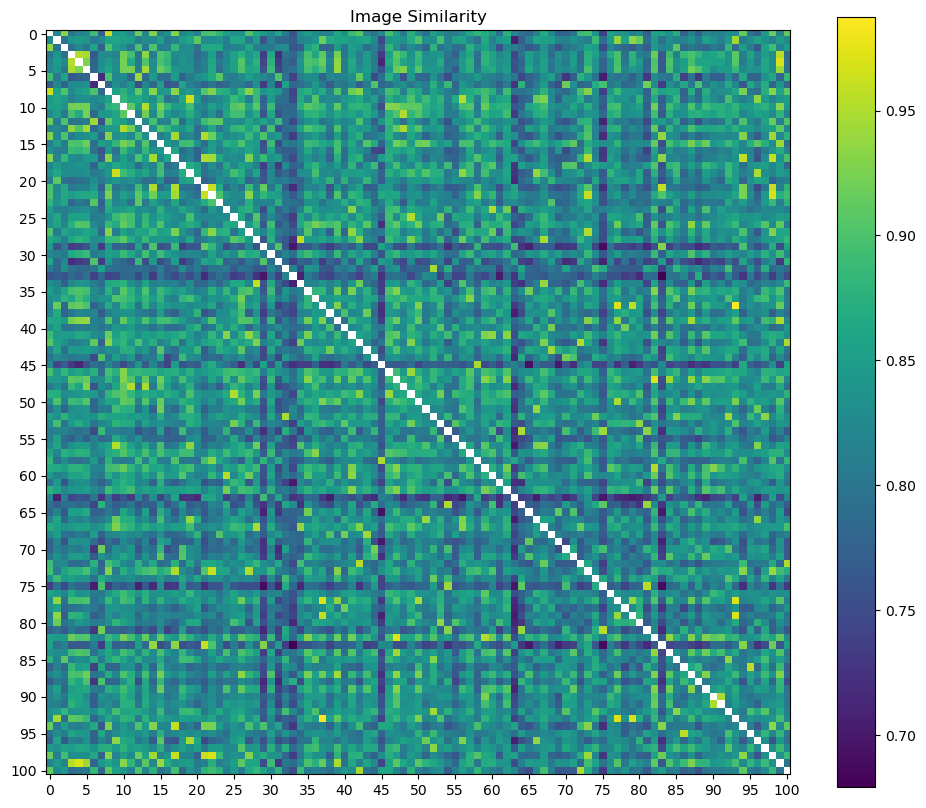

Image to class name similarity mean: 0.2001953125
Image to class name similarity std: 0.025604248046875
Image to class name similarity diagonal mean: 0.304443359375
Image to class name similarity diagonal std: 0.0145721435546875
Image to class name similarity non-diagonal mean: 0.19921875
Image to class name similarity non-diagonal std: 0.0234527587890625
Image to class name similarity diagonal mean to non-diagonal mean ratio: 1.5283203125
Rank 1: (4)beef_tartare - (99)tuna_tartare, similarity: 0.31640625
Rank 2: (99)tuna_tartare - (4)beef_tartare, similarity: 0.30078125
Rank 3: (52)gyoza - (32)dumplings, similarity: 0.294189453125
Rank 4: (64)miso_soup - (54)hot_and_sour_soup, similarity: 0.292724609375
Rank 5: (11)caesar_salad - (48)greek_salad, similarity: 0.287841796875
Rank 6: (54)hot_and_sour_soup - (64)miso_soup, similarity: 0.28759765625
Rank 7: (60)lobster_bisque - (24)clam_chowder, similarity: 0.28662109375
Rank 8: (54)hot_and_sour_soup - (41)french_onion_soup, similarity: 0.

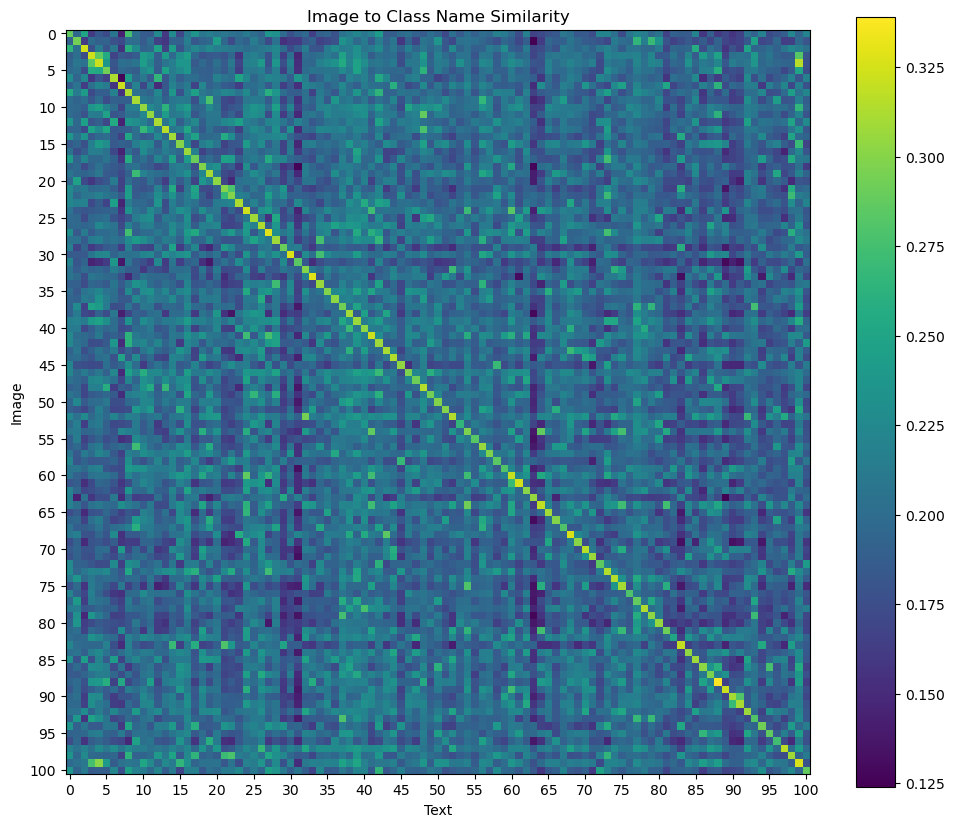

Rank 1: (4)beef_tartare - (99)tuna_tartare, error rate: 0.3433333333333333
Rank 2: (0)apple_pie - (8)bread_pudding, error rate: 0.29333333333333333
Rank 3: (93)steak - (37)filet_mignon, error rate: 0.2833333333333333
Rank 4: (54)hot_and_sour_soup - (41)french_onion_soup, error rate: 0.21666666666666667
Rank 5: (96)tacos - (19)chicken_quesadilla, error rate: 0.2
Rank 6: (54)hot_and_sour_soup - (64)miso_soup, error rate: 0.19333333333333333
Rank 7: (17)cheesecake - (73)panna_cotta, error rate: 0.16333333333333333
Rank 8: (11)caesar_salad - (48)greek_salad, error rate: 0.16333333333333333
Rank 9: (82)ravioli - (60)lobster_bisque, error rate: 0.15
Rank 10: (29)cup_cakes - (83)red_velvet_cake, error rate: 0.15
Rank 11: (53)hamburger - (80)pulled_pork_sandwich, error rate: 0.14333333333333334
Rank 12: (52)gyoza - (32)dumplings, error rate: 0.13
Rank 13: (58)ice_cream - (45)frozen_yogurt, error rate: 0.12666666666666668
Rank 14: (100)waffles - (42)french_toast, error rate: 0.12333333333333334

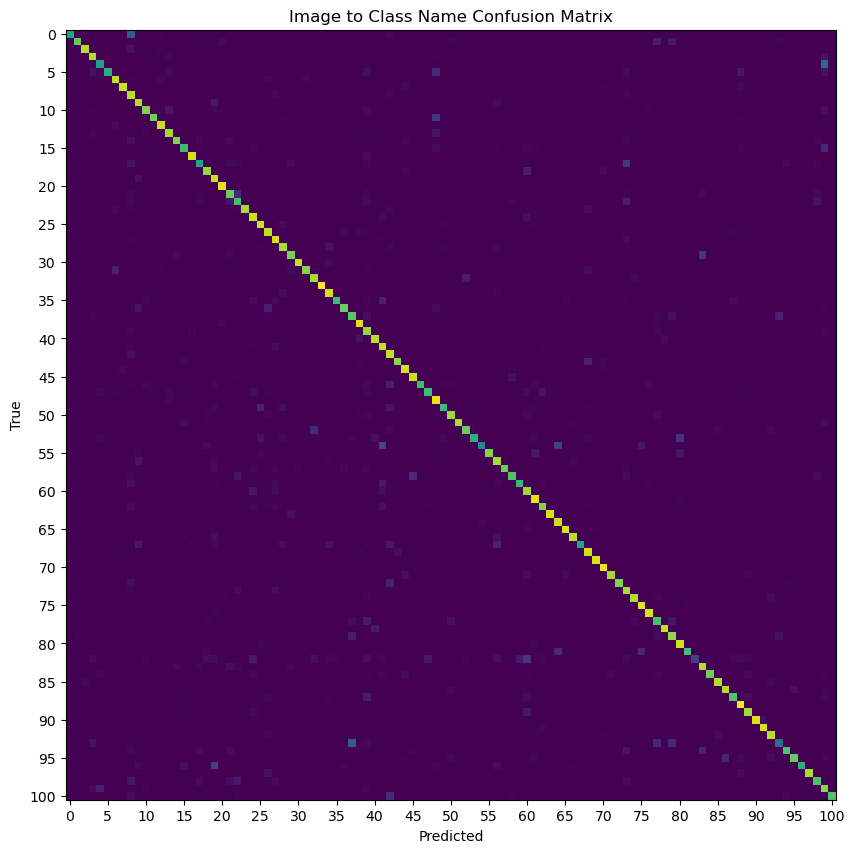

Image to text template (centroid) similarity mean: 0.2105712890625
Image to text template (centroid) similarity std: 0.02783203125
Image to text template (centroid) similarity diagonal mean: 0.3251953125
Image to text template (centroid) similarity diagonal std: 0.01323699951171875
Image to text template (centroid) similarity non-diagonal mean: 0.20947265625
Image to text template (centroid) similarity non-diagonal std: 0.0254364013671875
Image to text template (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.552734375
Rank 1: (4)beef_tartare - (99)tuna_tartare, similarity: 0.326416015625
Rank 2: (99)tuna_tartare - (4)beef_tartare, similarity: 0.32080078125
Rank 3: (52)gyoza - (32)dumplings, similarity: 0.3154296875
Rank 4: (54)hot_and_sour_soup - (64)miso_soup, similarity: 0.312255859375
Rank 5: (64)miso_soup - (54)hot_and_sour_soup, similarity: 0.3095703125
Rank 6: (68)onion_rings - (43)fried_calamari, similarity: 0.307861328125
Rank 7: (3)beef_carpaccio - (4)beef_ta

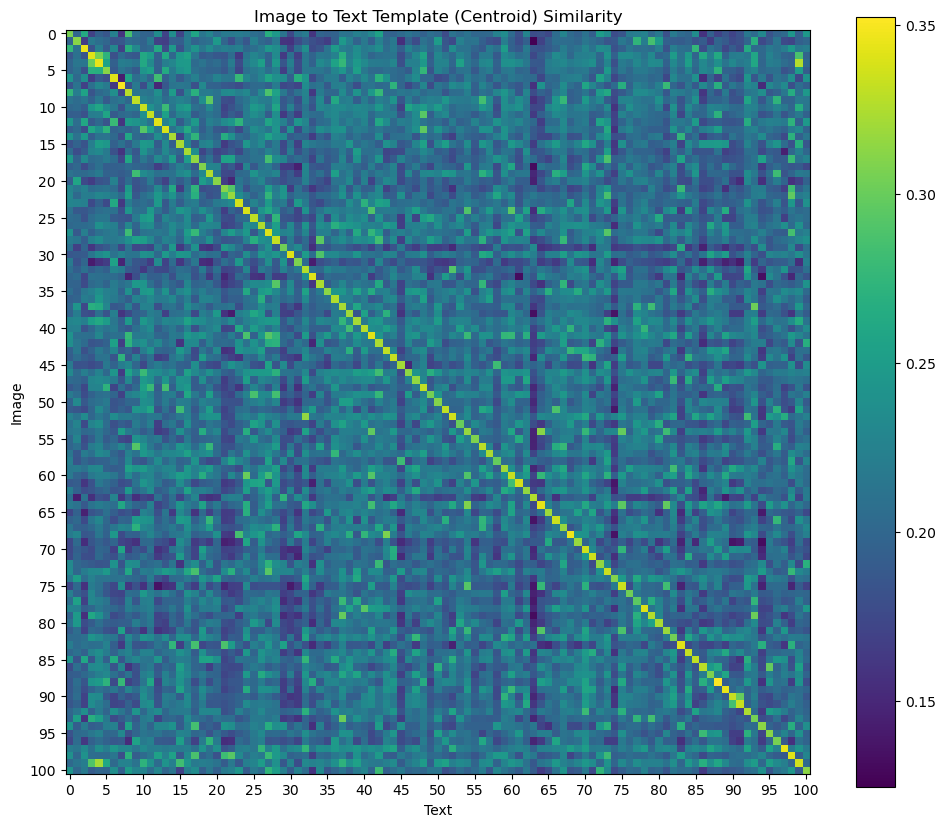

Rank 1: (93)steak - (37)filet_mignon, error rate: 0.3433333333333333
Rank 2: (54)hot_and_sour_soup - (64)miso_soup, error rate: 0.32
Rank 3: (0)apple_pie - (8)bread_pudding, error rate: 0.20333333333333334
Rank 4: (49)grilled_cheese_sandwich - (25)club_sandwich, error rate: 0.16
Rank 5: (29)cup_cakes - (83)red_velvet_cake, error rate: 0.15666666666666668
Rank 6: (99)tuna_tartare - (4)beef_tartare, error rate: 0.15333333333333332
Rank 7: (58)ice_cream - (45)frozen_yogurt, error rate: 0.14666666666666667
Rank 8: (54)hot_and_sour_soup - (41)french_onion_soup, error rate: 0.13
Rank 9: (79)prime_rib - (37)filet_mignon, error rate: 0.12666666666666668
Rank 10: (4)beef_tartare - (99)tuna_tartare, error rate: 0.12666666666666668
Rank 11: (17)cheesecake - (73)panna_cotta, error rate: 0.12
Rank 12: (21)chocolate_cake - (22)chocolate_mousse, error rate: 0.12
Rank 13: (77)pork_chop - (39)foie_gras, error rate: 0.12
Rank 14: (77)pork_chop - (37)filet_mignon, error rate: 0.10666666666666667
Rank 15:

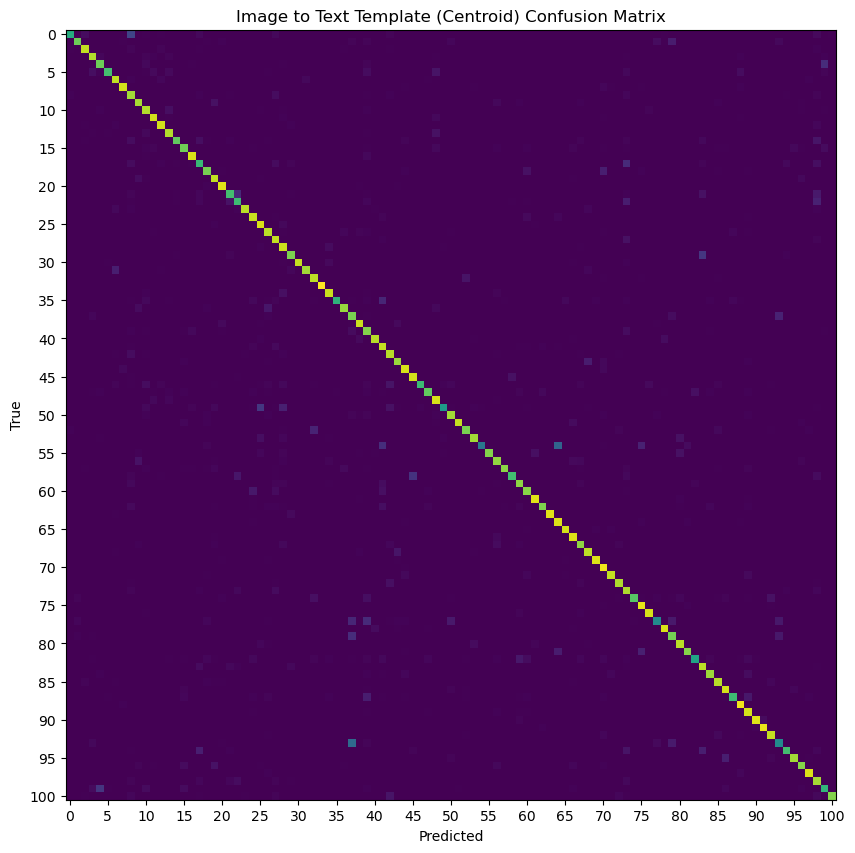

Image to text template (individual avg) similarity mean: 0.19405469298362732
Image to text template (individual avg) similarity std: 0.02567593939602375
Image to text template (individual avg) similarity diagonal mean: 0.2997756898403168
Image to text template (individual avg) similarity diagonal std: 0.01267746277153492
Image to text template (individual avg) similarity non-diagonal mean: 0.19299748539924622
Image to text template (individual avg) similarity non-diagonal std: 0.023480890318751335
Image to text template (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.5532621145248413
Rank 1: (4)beef_tartare - (99)tuna_tartare, similarity: 0.3017578125
Rank 2: (99)tuna_tartare - (4)beef_tartare, similarity: 0.2958984375
Rank 3: (54)hot_and_sour_soup - (64)miso_soup, similarity: 0.289306640625
Rank 4: (64)miso_soup - (54)hot_and_sour_soup, similarity: 0.2890625
Rank 5: (52)gyoza - (32)dumplings, similarity: 0.2890625
Rank 6: (68)onion_rings - (43)fried_calamari, s

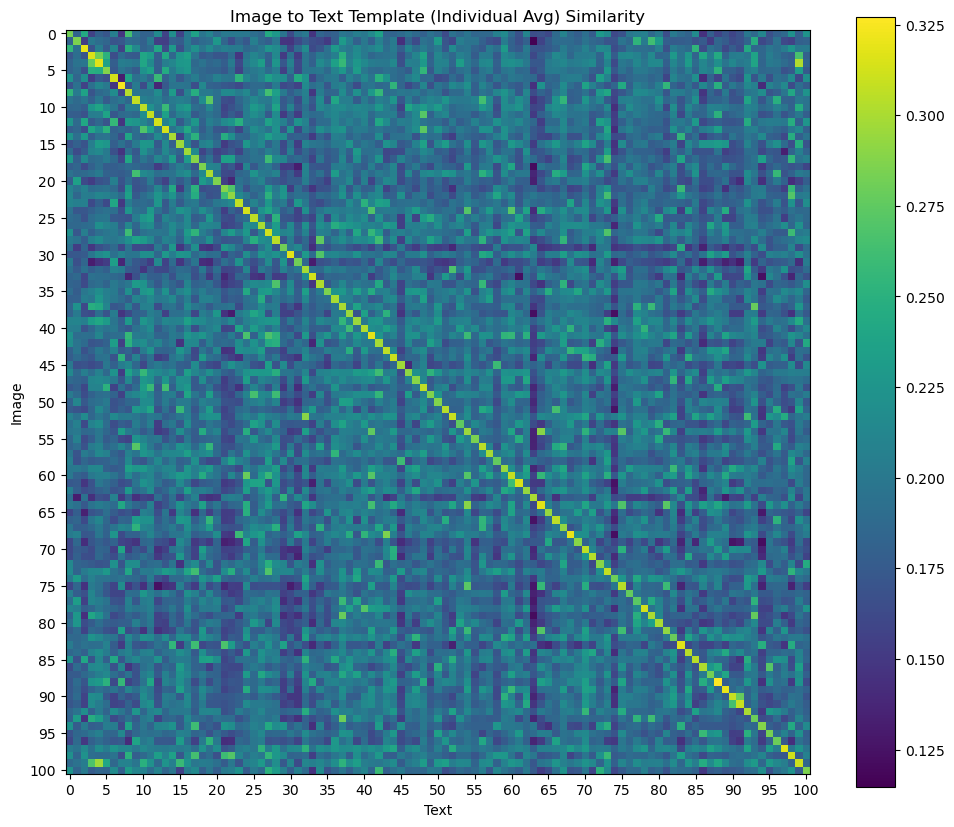

Rank 1: (93)steak - (37)filet_mignon, error rate: 0.4266666666666667
Rank 2: (54)hot_and_sour_soup - (64)miso_soup, error rate: 0.2866666666666667
Rank 3: (0)apple_pie - (8)bread_pudding, error rate: 0.20333333333333334
Rank 4: (79)prime_rib - (37)filet_mignon, error rate: 0.16333333333333333
Rank 5: (29)cup_cakes - (83)red_velvet_cake, error rate: 0.15666666666666668
Rank 6: (58)ice_cream - (45)frozen_yogurt, error rate: 0.15
Rank 7: (49)grilled_cheese_sandwich - (25)club_sandwich, error rate: 0.14666666666666667
Rank 8: (99)tuna_tartare - (4)beef_tartare, error rate: 0.14333333333333334
Rank 9: (4)beef_tartare - (99)tuna_tartare, error rate: 0.13333333333333333
Rank 10: (17)cheesecake - (73)panna_cotta, error rate: 0.12666666666666668
Rank 11: (77)pork_chop - (37)filet_mignon, error rate: 0.12333333333333334
Rank 12: (54)hot_and_sour_soup - (41)french_onion_soup, error rate: 0.12333333333333334
Rank 13: (21)chocolate_cake - (22)chocolate_mousse, error rate: 0.11333333333333333
Rank 1

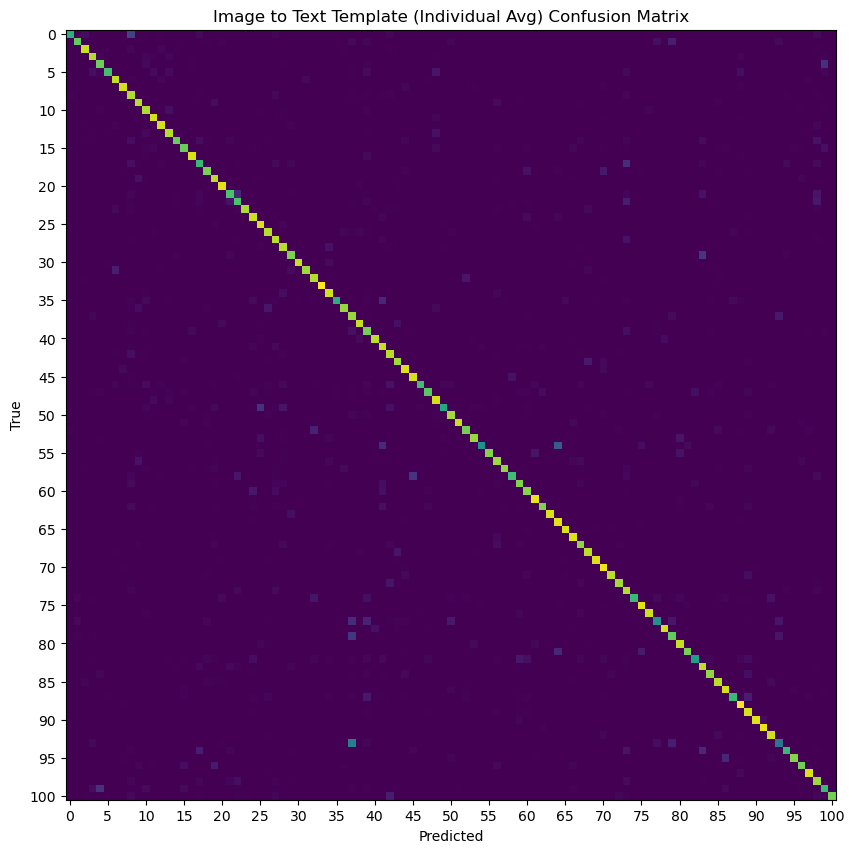

Image to original gpt-3 text (centroid) similarity mean: 0.2086181640625
Image to original gpt-3 text (centroid) similarity std: 0.0283355712890625
Image to original gpt-3 text (centroid) similarity diagonal mean: 0.3271484375
Image to original gpt-3 text (centroid) similarity diagonal std: 0.01421356201171875
Image to original gpt-3 text (centroid) similarity non-diagonal mean: 0.207275390625
Image to original gpt-3 text (centroid) similarity non-diagonal std: 0.02581787109375
Image to original gpt-3 text (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.578125
Rank 1: (4)beef_tartare - (99)tuna_tartare, similarity: 0.320556640625
Rank 2: (64)miso_soup - (54)hot_and_sour_soup, similarity: 0.31494140625
Rank 3: (52)gyoza - (32)dumplings, similarity: 0.314697265625
Rank 4: (54)hot_and_sour_soup - (64)miso_soup, similarity: 0.314453125
Rank 5: (75)pho - (54)hot_and_sour_soup, similarity: 0.308349609375
Rank 6: (99)tuna_tartare - (4)beef_tartare, similarity: 0.306884765625

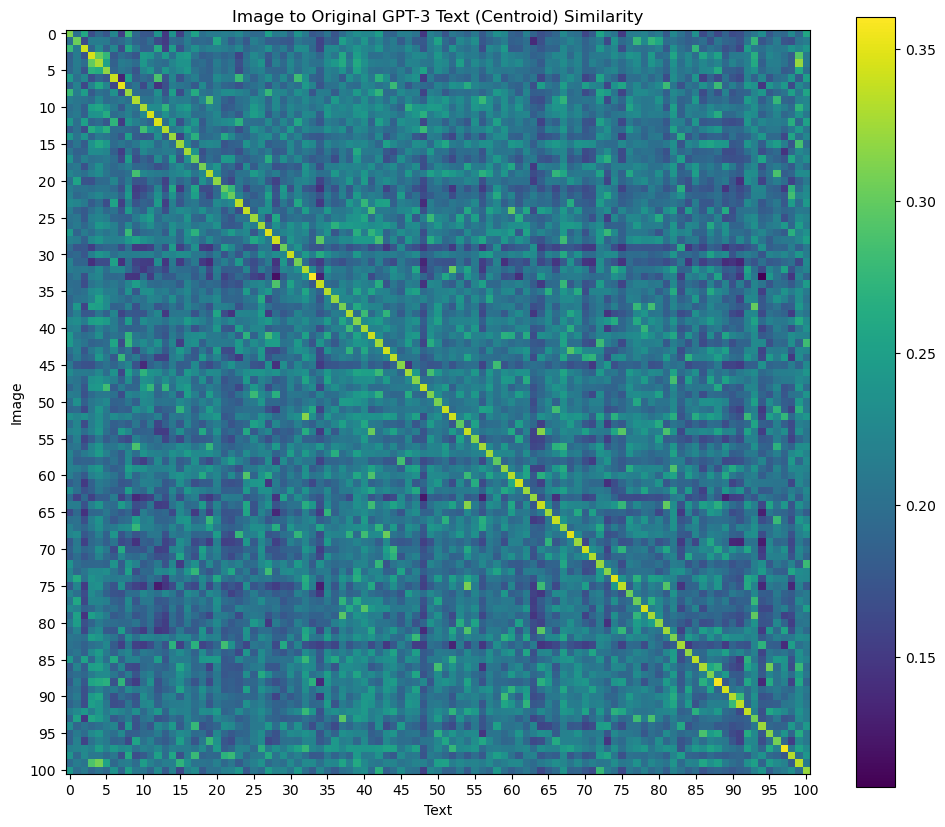

Rank 1: (4)beef_tartare - (99)tuna_tartare, error rate: 0.27
Rank 2: (93)steak - (37)filet_mignon, error rate: 0.22666666666666666
Rank 3: (37)filet_mignon - (93)steak, error rate: 0.19
Rank 4: (58)ice_cream - (45)frozen_yogurt, error rate: 0.16333333333333333
Rank 5: (29)cup_cakes - (83)red_velvet_cake, error rate: 0.12333333333333334
Rank 6: (0)apple_pie - (8)bread_pudding, error rate: 0.10666666666666667
Rank 7: (22)chocolate_mousse - (98)tiramisu, error rate: 0.1
Rank 8: (95)sushi - (86)sashimi, error rate: 0.09666666666666666
Rank 9: (21)chocolate_cake - (98)tiramisu, error rate: 0.09666666666666666
Rank 10: (93)steak - (79)prime_rib, error rate: 0.09666666666666666
Rank 11: (15)ceviche - (99)tuna_tartare, error rate: 0.08666666666666667
Rank 12: (43)fried_calamari - (68)onion_rings, error rate: 0.08333333333333333
Rank 13: (73)panna_cotta - (27)creme_brulee, error rate: 0.08
Rank 14: (22)chocolate_mousse - (21)chocolate_cake, error rate: 0.08
Rank 15: (49)grilled_cheese_sandwich 

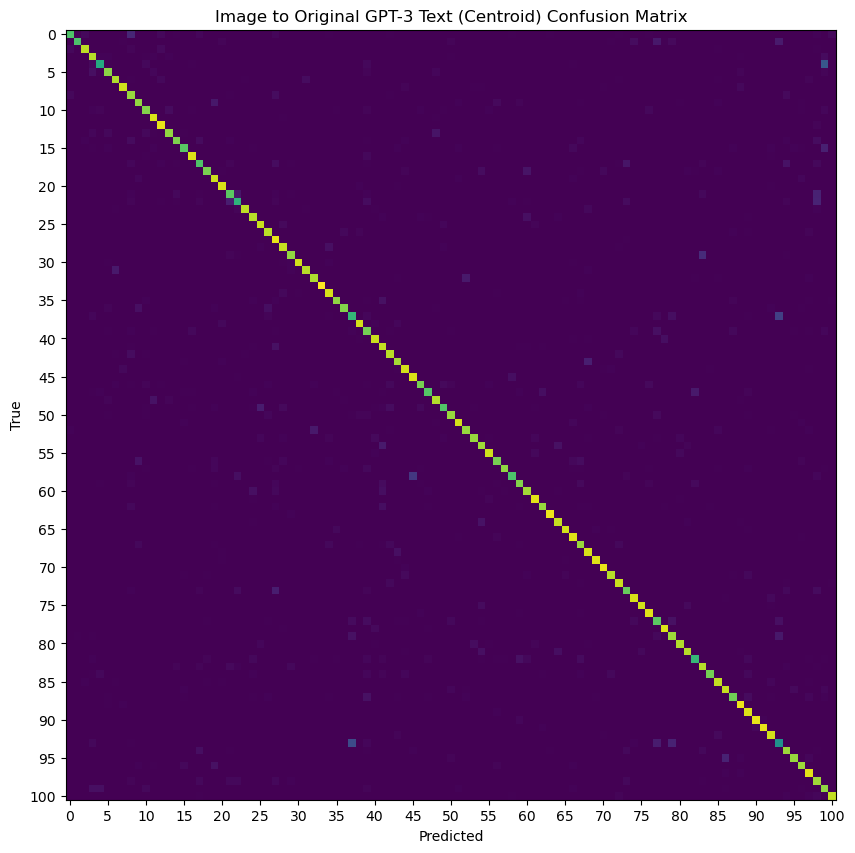

Image to original gpt-3 text (individual avg) similarity mean: 0.19644682109355927
Image to original gpt-3 text (individual avg) similarity std: 0.026626577600836754
Image to original gpt-3 text (individual avg) similarity diagonal mean: 0.30806678533554077
Image to original gpt-3 text (individual avg) similarity diagonal std: 0.013366647064685822
Image to original gpt-3 text (individual avg) similarity non-diagonal mean: 0.19533061981201172
Image to original gpt-3 text (individual avg) similarity non-diagonal std: 0.024257812649011612
Image to original gpt-3 text (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.577155590057373
Rank 1: (4)beef_tartare - (99)tuna_tartare, similarity: 0.30029296875
Rank 2: (64)miso_soup - (54)hot_and_sour_soup, similarity: 0.295166015625
Rank 3: (52)gyoza - (32)dumplings, similarity: 0.294189453125
Rank 4: (54)hot_and_sour_soup - (64)miso_soup, similarity: 0.293701171875
Rank 5: (75)pho - (54)hot_and_sour_soup, similarity: 0.289062

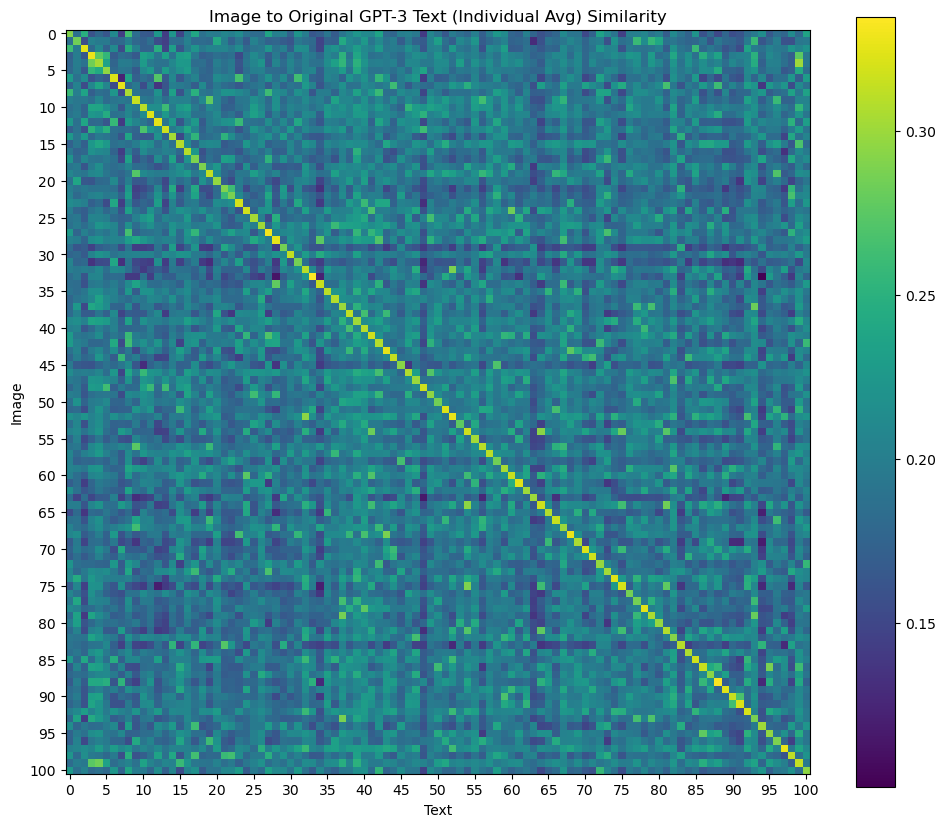

Rank 1: (93)steak - (37)filet_mignon, error rate: 0.44
Rank 2: (4)beef_tartare - (99)tuna_tartare, error rate: 0.38
Rank 3: (95)sushi - (86)sashimi, error rate: 0.15333333333333332
Rank 4: (0)apple_pie - (8)bread_pudding, error rate: 0.13333333333333333
Rank 5: (79)prime_rib - (37)filet_mignon, error rate: 0.13
Rank 6: (29)cup_cakes - (83)red_velvet_cake, error rate: 0.12333333333333334
Rank 7: (22)chocolate_mousse - (21)chocolate_cake, error rate: 0.10333333333333333
Rank 8: (32)dumplings - (52)gyoza, error rate: 0.09333333333333334
Rank 9: (22)chocolate_mousse - (98)tiramisu, error rate: 0.08666666666666667
Rank 10: (1)baby_back_ribs - (93)steak, error rate: 0.08666666666666667
Rank 11: (77)pork_chop - (37)filet_mignon, error rate: 0.08333333333333333
Rank 12: (17)cheesecake - (73)panna_cotta, error rate: 0.07666666666666666
Rank 13: (31)donuts - (6)beignets, error rate: 0.07666666666666666
Rank 14: (1)baby_back_ribs - (77)pork_chop, error rate: 0.07333333333333333
Rank 15: (21)choco

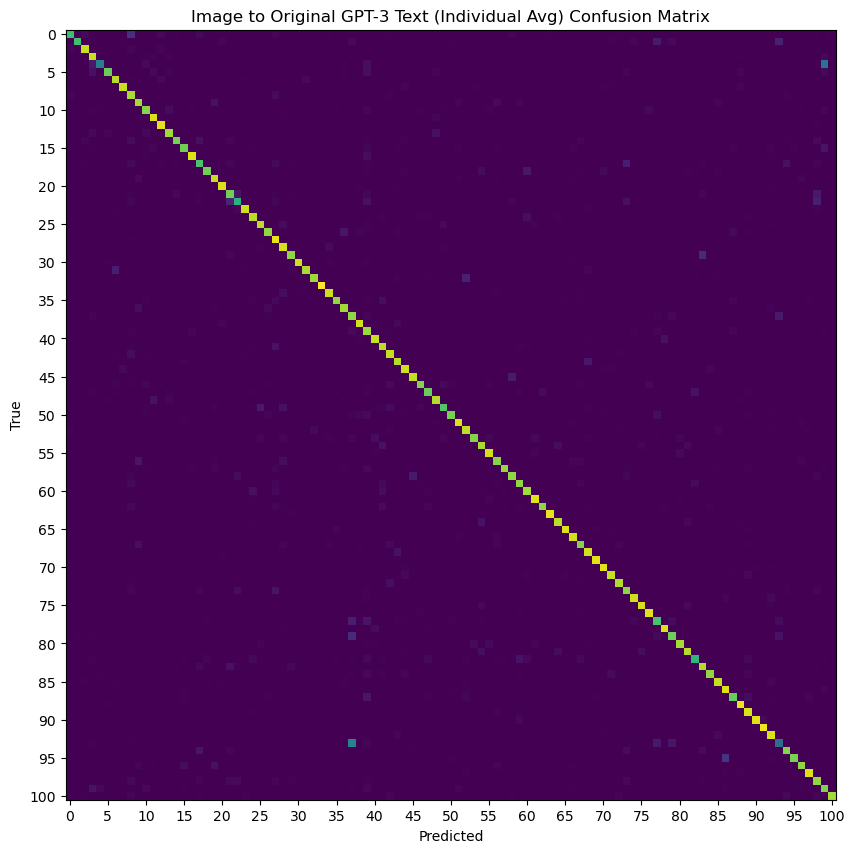

Image to filtered gpt-3 text (centroid) similarity mean: 0.20751953125
Image to filtered gpt-3 text (centroid) similarity std: 0.0287017822265625
Image to filtered gpt-3 text (centroid) similarity diagonal mean: 0.3271484375
Image to filtered gpt-3 text (centroid) similarity diagonal std: 0.014251708984375
Image to filtered gpt-3 text (centroid) similarity non-diagonal mean: 0.206298828125
Image to filtered gpt-3 text (centroid) similarity non-diagonal std: 0.02618408203125
Image to filtered gpt-3 text (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.5859375
Rank 1: (4)beef_tartare - (99)tuna_tartare, similarity: 0.31982421875
Rank 2: (54)hot_and_sour_soup - (64)miso_soup, similarity: 0.315185546875
Rank 3: (52)gyoza - (32)dumplings, similarity: 0.314208984375
Rank 4: (64)miso_soup - (54)hot_and_sour_soup, similarity: 0.31298828125
Rank 5: (99)tuna_tartare - (4)beef_tartare, similarity: 0.3076171875
Rank 6: (86)sashimi - (95)sushi, similarity: 0.306640625
Rank 7: (75)p

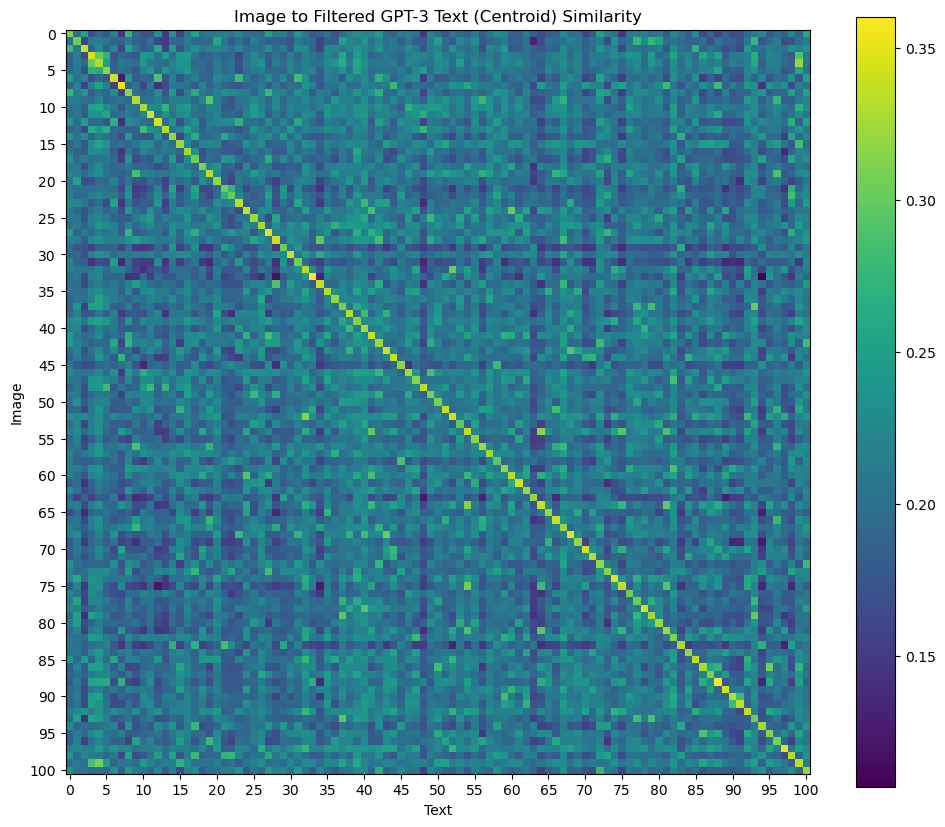

Rank 1: (93)steak - (37)filet_mignon, error rate: 0.23333333333333334
Rank 2: (4)beef_tartare - (99)tuna_tartare, error rate: 0.23
Rank 3: (58)ice_cream - (45)frozen_yogurt, error rate: 0.20333333333333334
Rank 4: (37)filet_mignon - (93)steak, error rate: 0.18
Rank 5: (29)cup_cakes - (83)red_velvet_cake, error rate: 0.12333333333333334
Rank 6: (22)chocolate_mousse - (98)tiramisu, error rate: 0.11
Rank 7: (21)chocolate_cake - (98)tiramisu, error rate: 0.1
Rank 8: (0)apple_pie - (8)bread_pudding, error rate: 0.09666666666666666
Rank 9: (22)chocolate_mousse - (21)chocolate_cake, error rate: 0.09
Rank 10: (95)sushi - (86)sashimi, error rate: 0.08333333333333333
Rank 11: (43)fried_calamari - (68)onion_rings, error rate: 0.08333333333333333
Rank 12: (73)panna_cotta - (27)creme_brulee, error rate: 0.08
Rank 13: (93)steak - (77)pork_chop, error rate: 0.08
Rank 14: (93)steak - (79)prime_rib, error rate: 0.08
Rank 15: (49)grilled_cheese_sandwich - (25)club_sandwich, error rate: 0.076666666666666

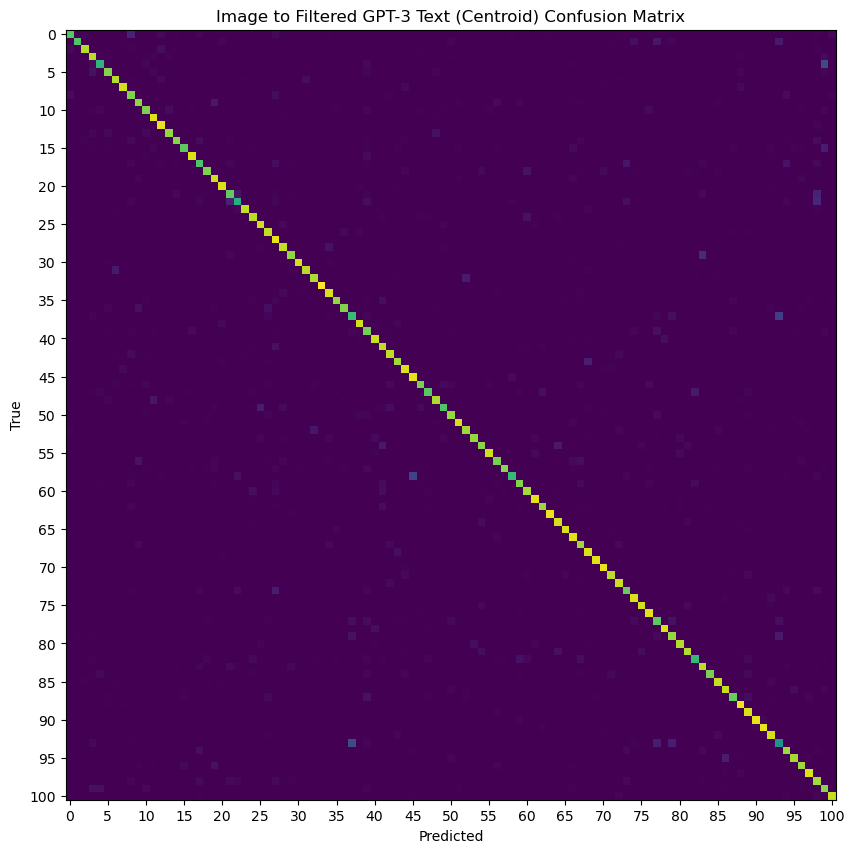

Image to filtered gpt-3 text (individual avg) similarity mean: 0.19631484150886536
Image to filtered gpt-3 text (individual avg) similarity std: 0.027047593146562576
Image to filtered gpt-3 text (individual avg) similarity diagonal mean: 0.30961865186691284
Image to filtered gpt-3 text (individual avg) similarity diagonal std: 0.014074837788939476
Image to filtered gpt-3 text (individual avg) similarity non-diagonal mean: 0.19518180191516876
Image to filtered gpt-3 text (individual avg) similarity non-diagonal std: 0.024642355740070343
Image to filtered gpt-3 text (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.5863089561462402
Rank 1: (4)beef_tartare - (99)tuna_tartare, similarity: 0.308349609375
Rank 2: (54)hot_and_sour_soup - (64)miso_soup, similarity: 0.297119140625
Rank 3: (64)miso_soup - (54)hot_and_sour_soup, similarity: 0.295654296875
Rank 4: (52)gyoza - (32)dumplings, similarity: 0.2939453125
Rank 5: (75)pho - (54)hot_and_sour_soup, similarity: 0.289550

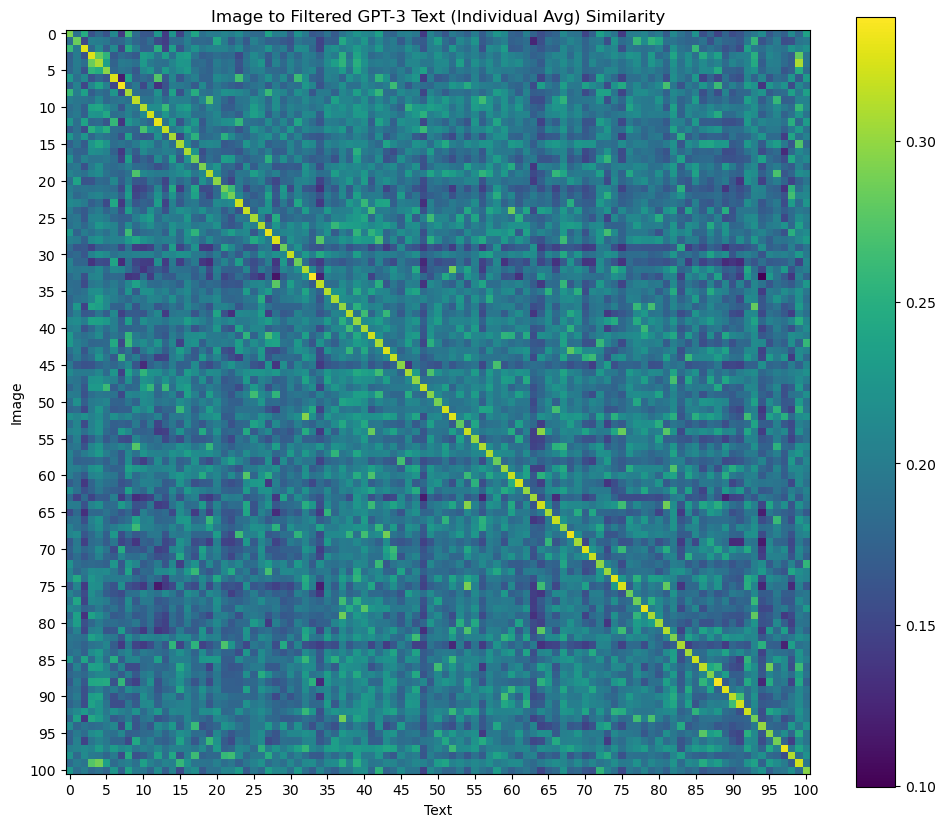

Rank 1: (4)beef_tartare - (99)tuna_tartare, error rate: 0.48
Rank 2: (93)steak - (37)filet_mignon, error rate: 0.43666666666666665
Rank 3: (95)sushi - (86)sashimi, error rate: 0.15333333333333332
Rank 4: (0)apple_pie - (8)bread_pudding, error rate: 0.12666666666666668
Rank 5: (29)cup_cakes - (83)red_velvet_cake, error rate: 0.12666666666666668
Rank 6: (79)prime_rib - (37)filet_mignon, error rate: 0.12333333333333334
Rank 7: (15)ceviche - (99)tuna_tartare, error rate: 0.10666666666666667
Rank 8: (32)dumplings - (52)gyoza, error rate: 0.09333333333333334
Rank 9: (93)steak - (79)prime_rib, error rate: 0.09
Rank 10: (22)chocolate_mousse - (21)chocolate_cake, error rate: 0.08666666666666667
Rank 11: (43)fried_calamari - (68)onion_rings, error rate: 0.08333333333333333
Rank 12: (58)ice_cream - (45)frozen_yogurt, error rate: 0.08333333333333333
Rank 13: (77)pork_chop - (37)filet_mignon, error rate: 0.08
Rank 14: (22)chocolate_mousse - (98)tiramisu, error rate: 0.08
Rank 15: (31)donuts - (6)be

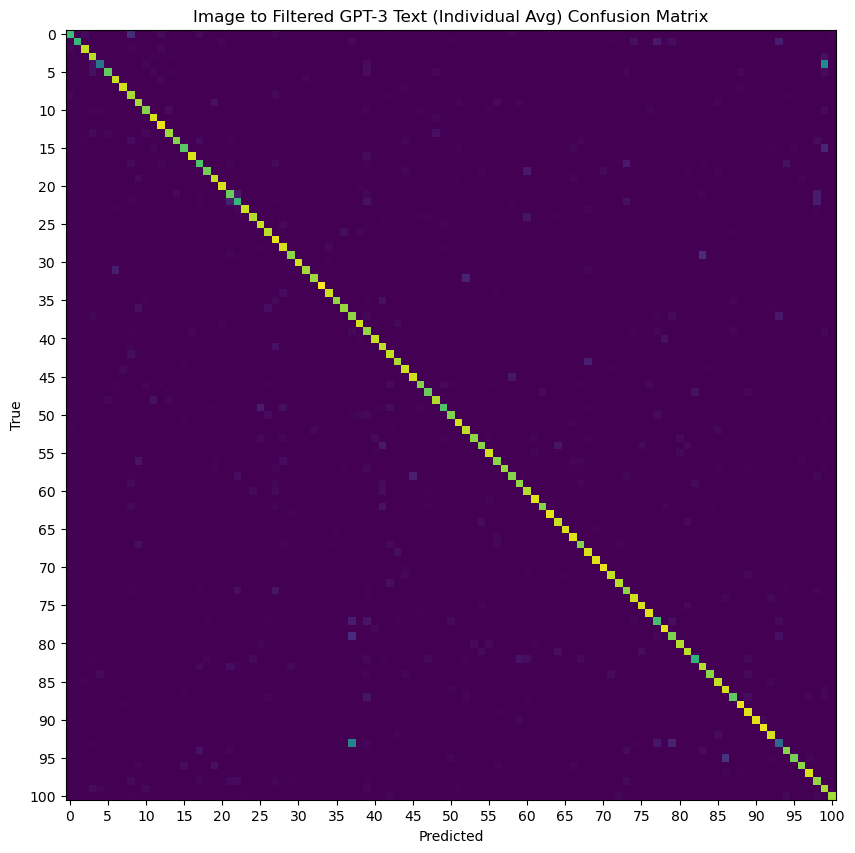

In [35]:
# Auto-similarity of image features
visualize_auto_similarity(img_masked_similarity, 'Image')

# Image to text similarity
visualize_cross_similarity(img_cls_name_similarity, cls_name_cm, 'Image to Class Name')
visualize_cross_similarity(img_template_cls_similarity, template_cls_cm, 'Image to Text Template (Centroid)')
visualize_cross_similarity(img_template_text_similarity, template_text_cm, 'Image to Text Template (Individual Avg)')
visualize_cross_similarity(img_original_gpt3_cls_similarity, original_gpt3_cls_cm, 'Image to Original GPT-3 Text (Centroid)')
visualize_cross_similarity(img_original_gpt3_text_similarity, original_gpt3_text_cm, 'Image to Original GPT-3 Text (Individual Avg)')
visualize_cross_similarity(img_filtered_gpt3_cls_similarity, filtered_gpt3_cls_cm, 'Image to Filtered GPT-3 Text (Centroid)')
visualize_cross_similarity(img_filtered_gpt3_text_similarity, filtered_gpt3_text_cm, 'Image to Filtered GPT-3 Text (Individual Avg)')

In [36]:
# Concatenate all features and labels to be used for plotting
all_label_ids = np.concatenate([cls_name_label_ids, template_label_ids, original_gpt3_label_ids, filtered_gpt3_label_ids])
all_features = np.concatenate([cls_name_features, template_text_features, original_gpt3_text_features, filtered_gpt3_text_features])

cls_name_start_idx = 0
cls_name_end_idx = len(cls_name_features)
template_start_idx = len(cls_name_features)
template_end_idx = len(cls_name_features) + len(template_text_features)
original_gpt3_start_idx = len(cls_name_features) + len(template_text_features)
original_gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features)
filtered_gpt3_start_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features)
filtered_gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features) + len(filtered_gpt3_text_features)

In [37]:
import sklearn.manifold

tsne = sklearn.manifold.TSNE(n_components=2, random_state=42, metric='cosine', perplexity=100)
transformed_features = tsne.fit_transform(all_features)

In [38]:
import matplotlib.pyplot as plt

def plot_features_2d(features, label_ids, title):
    plt.figure(figsize=(10, 10))
    plt.scatter(features[:, 0], features[:, 1], c=label_ids, cmap='hsv')
    for label_id in range(len(cls_names_sorted)):
        plt.annotate(label_id, (features[label_ids == label_id, 0].mean(), features[label_ids == label_id, 1].mean()), ha='center', va='center', fontsize=12)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.show()

Rank 1: (45)frozen_yogurt - (58)ice_cream, similarity: 0.9013671875
Rank 2: (72)pancakes - (100)waffles, similarity: 0.8916015625
Rank 3: (21)chocolate_cake - (22)chocolate_mousse, similarity: 0.890625
Rank 4: (37)filet_mignon - (93)steak, similarity: 0.87744140625
Rank 5: (38)fish_and_chips - (40)french_fries, similarity: 0.87646484375
Rank 6: (66)nachos - (96)tacos, similarity: 0.873046875
Rank 7: (86)sashimi - (95)sushi, similarity: 0.87158203125
Rank 8: (4)beef_tartare - (99)tuna_tartare, similarity: 0.86572265625
Rank 9: (76)pizza - (93)steak, similarity: 0.865234375
Rank 10: (21)chocolate_cake - (29)cup_cakes, similarity: 0.8642578125


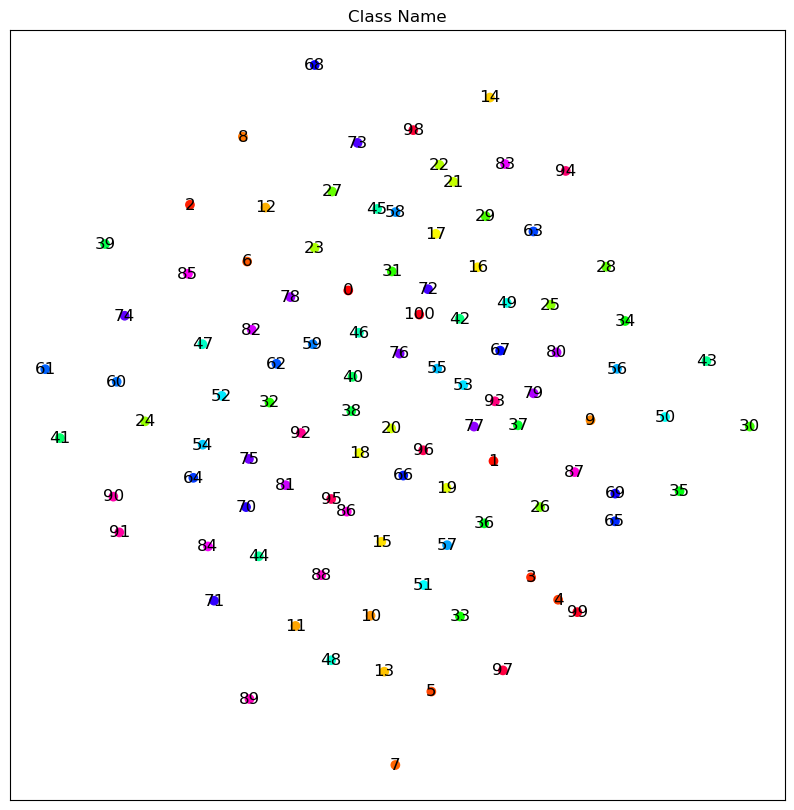

Rank 1: (21)chocolate_cake - (22)chocolate_mousse, similarity: 0.90283203125
Rank 2: (45)frozen_yogurt - (58)ice_cream, similarity: 0.8994140625
Rank 3: (4)beef_tartare - (99)tuna_tartare, similarity: 0.8974609375
Rank 4: (86)sashimi - (95)sushi, similarity: 0.8896484375
Rank 5: (37)filet_mignon - (93)steak, similarity: 0.8876953125
Rank 6: (72)pancakes - (100)waffles, similarity: 0.88720703125
Rank 7: (53)hamburger - (93)steak, similarity: 0.88671875
Rank 8: (77)pork_chop - (93)steak, similarity: 0.88134765625
Rank 9: (53)hamburger - (55)hot_dog, similarity: 0.86474609375
Rank 10: (79)prime_rib - (93)steak, similarity: 0.86474609375


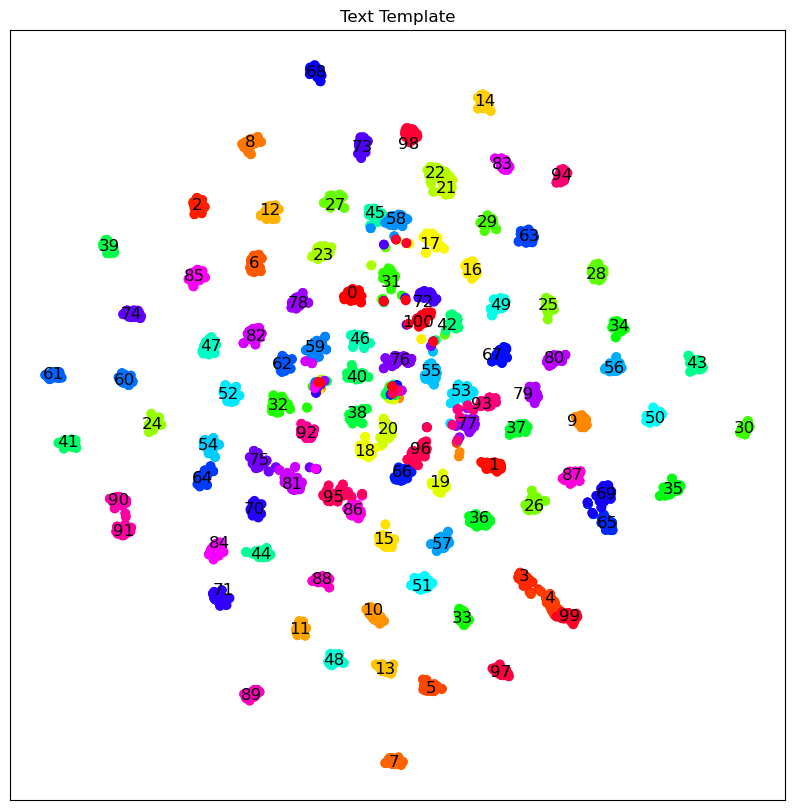

Rank 1: (37)filet_mignon - (93)steak, similarity: 0.93505859375
Rank 2: (45)frozen_yogurt - (58)ice_cream, similarity: 0.9306640625
Rank 3: (4)beef_tartare - (99)tuna_tartare, similarity: 0.91650390625
Rank 4: (86)sashimi - (95)sushi, similarity: 0.91552734375
Rank 5: (79)prime_rib - (93)steak, similarity: 0.9150390625
Rank 6: (77)pork_chop - (93)steak, similarity: 0.90576171875
Rank 7: (53)hamburger - (55)hot_dog, similarity: 0.90478515625
Rank 8: (21)chocolate_cake - (22)chocolate_mousse, similarity: 0.90185546875
Rank 9: (72)pancakes - (100)waffles, similarity: 0.90087890625
Rank 10: (54)hot_and_sour_soup - (64)miso_soup, similarity: 0.8984375


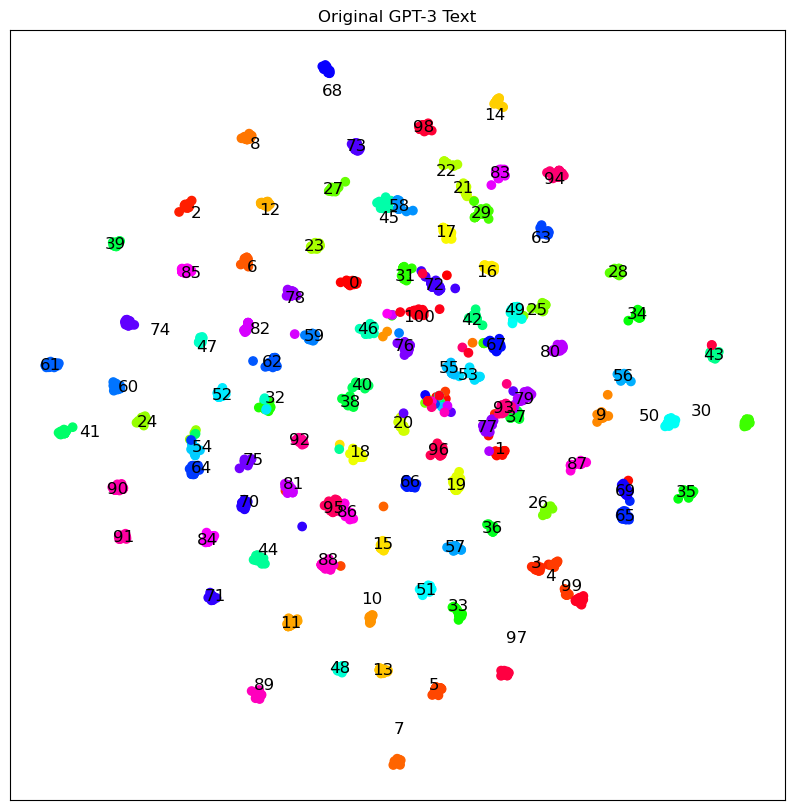

Rank 1: (37)filet_mignon - (93)steak, similarity: 0.9365234375
Rank 2: (45)frozen_yogurt - (58)ice_cream, similarity: 0.927734375
Rank 3: (86)sashimi - (95)sushi, similarity: 0.9140625
Rank 4: (79)prime_rib - (93)steak, similarity: 0.91162109375
Rank 5: (4)beef_tartare - (99)tuna_tartare, similarity: 0.91015625
Rank 6: (77)pork_chop - (93)steak, similarity: 0.90576171875
Rank 7: (53)hamburger - (55)hot_dog, similarity: 0.904296875
Rank 8: (72)pancakes - (100)waffles, similarity: 0.90087890625
Rank 9: (53)hamburger - (93)steak, similarity: 0.89697265625
Rank 10: (21)chocolate_cake - (22)chocolate_mousse, similarity: 0.89599609375


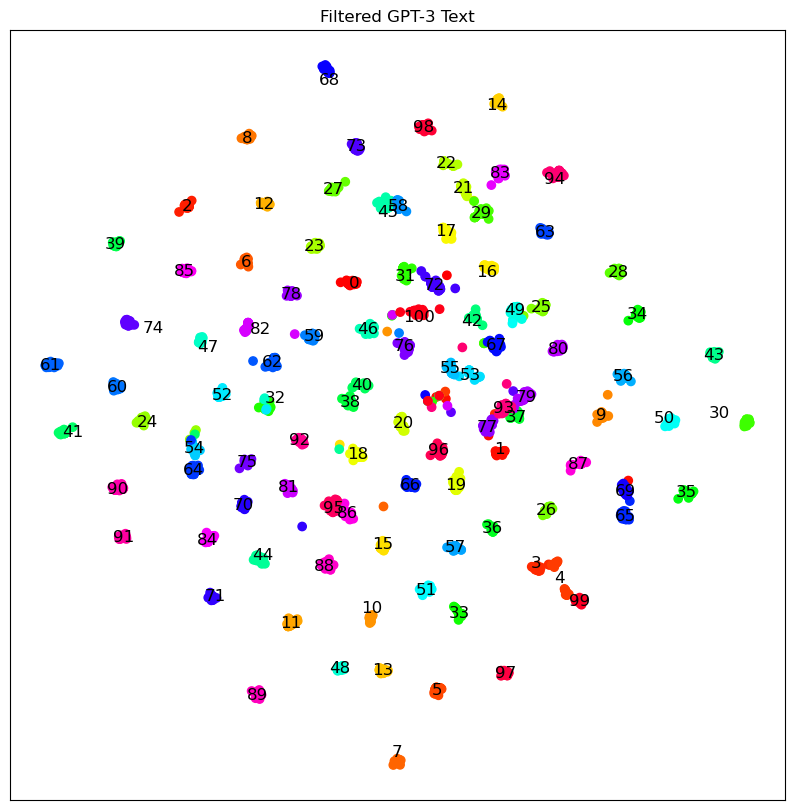

In [39]:
print_top_pairs(np.triu(cls_name_masked_similarity, k=1), 'similarity')
plot_features_2d(transformed_features[cls_name_start_idx:cls_name_end_idx], all_label_ids[cls_name_start_idx:cls_name_end_idx], 'Class Name')
print_top_pairs(np.triu(template_masked_similarity, k=1), 'similarity')
plot_features_2d(transformed_features[template_start_idx:template_end_idx], all_label_ids[template_start_idx:template_end_idx], 'Text Template')
print_top_pairs(np.triu(original_gpt3_masked_similarity, k=1), 'similarity')
plot_features_2d(transformed_features[original_gpt3_start_idx:original_gpt3_end_idx], all_label_ids[original_gpt3_start_idx:original_gpt3_end_idx], 'Original GPT-3 Text')
print_top_pairs(np.triu(filtered_gpt3_masked_similarity, k=1), 'similarity')
plot_features_2d(transformed_features[filtered_gpt3_start_idx:filtered_gpt3_end_idx], all_label_ids[filtered_gpt3_start_idx:filtered_gpt3_end_idx], 'Filtered GPT-3 Text')